<a href="https://colab.research.google.com/github/FernandoJungLau/Segment_anything_in_keras/blob/main/segment_anything_in_keras_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything in KerasHub!

**Author:** Tirth Patel, Ian Stenbit, Divyashree Sreepathihalli<br><br>
**Date created:** 2024/10/1<br><br>
**Last modified:** 2024/10/1<br><br>
**Description:** Segment anything using text, box, and points prompts in KerasHub.<br><br>
**Modified by:** Fernando Jung Lau

## Overview

The Segment Anything Model (SAM) produces high quality object masks from input prompts
such as points or boxes, and it can be used to generate masks for all objects in an
image. It has been trained on a
[dataset](https://segment-anything.com/dataset/index.html) of 11 million images and 1.1
billion masks, and has strong zero-shot performance on a variety of segmentation tasks.

In this guide, we will show how to use KerasHub's implementation of the
[Segment Anything Model](https://github.com/facebookresearch/segment-anything)
and show how powerful TensorFlow's and JAX's performance boost is.

First, let's get all our dependencies and images for our demo.

In [1]:
!!pip install -Uq git+https://github.com/keras-team/keras-hub.git
!!pip install -Uq keras

['\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.4 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b \x1b1.4/1.4 MB\x1b \x1b42.1 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.4/1.4 MB\x1b \x1b22.6 MB/s\x1b eta \x1b0:00:00\x1b',
 "\x1b[?25h\x1bERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.",
 'keras-nlp 0.21.1 requires keras-hub==0.21.1, but you have keras-hub 0.23.0.dev0 which is incompatible.\x1b\x1b',
 '\x1b']

In [2]:
!!wget -q https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

[]

## Choose your backend

With Keras 3, you can choose to use your favorite backend!

In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import timeit
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import ops
import keras_hub

## Helper functions

Let's define some helper functions for visulazing the images, prompts, and the
segmentation results.

In [29]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="black", facecolor=(0, 0, 0, 0), lw=2)
    )


def inference_resizing(image, pad=True):
    # Compute Preprocess Shape
    image = ops.cast(image, dtype="float32")
    old_h, old_w = image.shape[0], image.shape[1]
    scale = 1024 * 1.0 / max(old_h, old_w)
    new_h = old_h * scale
    new_w = old_w * scale
    preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)

    # Resize the image
    image = ops.image.resize(image[None, ...], preprocess_shape)[0]

    # Pad the shorter side
    if pad:
        pixel_mean = ops.array([123.675, 116.28, 103.53])
        pixel_std = ops.array([58.395, 57.12, 57.375])
        image = (image - pixel_mean) / pixel_std
        h, w = image.shape[0], image.shape[1]
        pad_h = 1024 - h
        pad_w = 1024 - w
        image = ops.pad(image, [(0, pad_h), (0, pad_w), (0, 0)])
        # KerasHub now rescales the images and normalizes them.
        # Just unnormalize such that when KerasHub normalizes them
        # again, the padded values map to 0.
        image = image * pixel_std + pixel_mean
    return image


## Get the pretrained SAM model

We can initialize a trained SAM model using KerasHub's `from_preset` factory method. Here,
we use the huge ViT backbone trained on the SA-1B dataset (`sam_huge_sa1b`) for
high-quality segmentation masks. You can also use one of the `sam_large_sa1b` or
`sam_base_sa1b` for better performance (at the cost of decreasing quality of segmentation
masks).

In [5]:
model = keras_hub.models.SAMImageSegmenter.from_preset("sam_huge_sa1b")

## Understanding Prompts

Segment Anything allows prompting an image using points, boxes, and masks:

1. Point prompts are the most basic of all: the model tries to guess the object given a
point on an image. The point can either be a foreground point (i.e. the desired
segmentation mask contains the point in it) or a backround point (i.e. the point lies
outside the desired mask).
2. Another way to prompt the model is using boxes. Given a bounding box, the model tries
to segment the object contained in it.
3. Finally, the model can also be prompted using a mask itself. This is useful, for
instance, to refine the borders of a previously predicted or known segmentation mask.

What makes the model incredibly powerful is the ability to combine the prompts above.
Point, box, and mask prompts can be combined in several different ways to achieve the
best result.

Let's see the semantics of passing these prompts to the Segment Anything model in
KerasHub. Input to the SAM model is a dictionary with keys:

1. `"images"`: A batch of images to segment. Must be of shape `(B, 1024, 1024, 3)`.
2. `"points"`: A batch of point prompts. Each point is an `(x, y)` coordinate originating
from the top-left corner of the image. In other works, each point is of the form `(r, c)`
where `r` and `c` are the row and column of the pixel in the image. Must be of shape `(B,
N, 2)`.
3. `"labels"`: A batch of labels for the given points. `1` represents foreground points
and `0` represents background points. Must be of shape `(B, N)`.
4. `"boxes"`: A batch of boxes. Note that the model only accepts one box per batch.
Hence, the expected shape is `(B, 1, 2, 2)`. Each box is a collection of 2 points: the
top left corner and the bottom right corner of the box. The points here follow the same
semantics as the point prompts. Here the `1` in the second dimension represents the
presence of box prompts. If the box prompts are missing, a placeholder input of shape
`(B, 0, 2, 2)` must be passed.
5. `"masks"`: A batch of masks. Just like box prompts, only one mask prompt per image is
allowed. The shape of the input mask must be `(B, 1, 256, 256, 1)` if they are present
and `(B, 0, 256, 256, 1)` for missing mask prompt.

Placeholder prompts are only required when calling the model directly (i.e.
`model(...)`). When calling the `predict` method, missing prompts can be omitted from the
input dictionary.

## Point prompts

First, let's segment an image using point prompts. We load the image and resize it to
shape `(1024, 1024)`, the image size the pretrained SAM model expects.

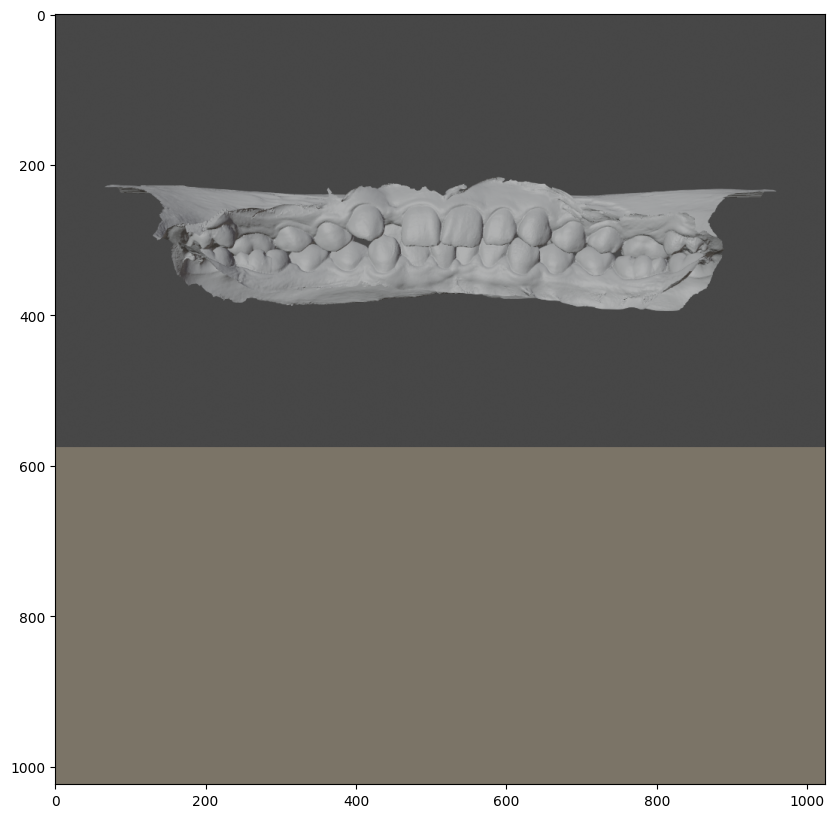

In [30]:
from keras.utils import load_img, img_to_array

image = load_img("/content/frontal_ID10445-00-Main-X.png")
image = img_to_array(image)
image = inference_resizing(image)

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
plt.axis("on")
plt.show()

Next, we will define the point on the object we want to segment. Let's try to segment the
truck's window pane at coordinates `(284, 213)`.

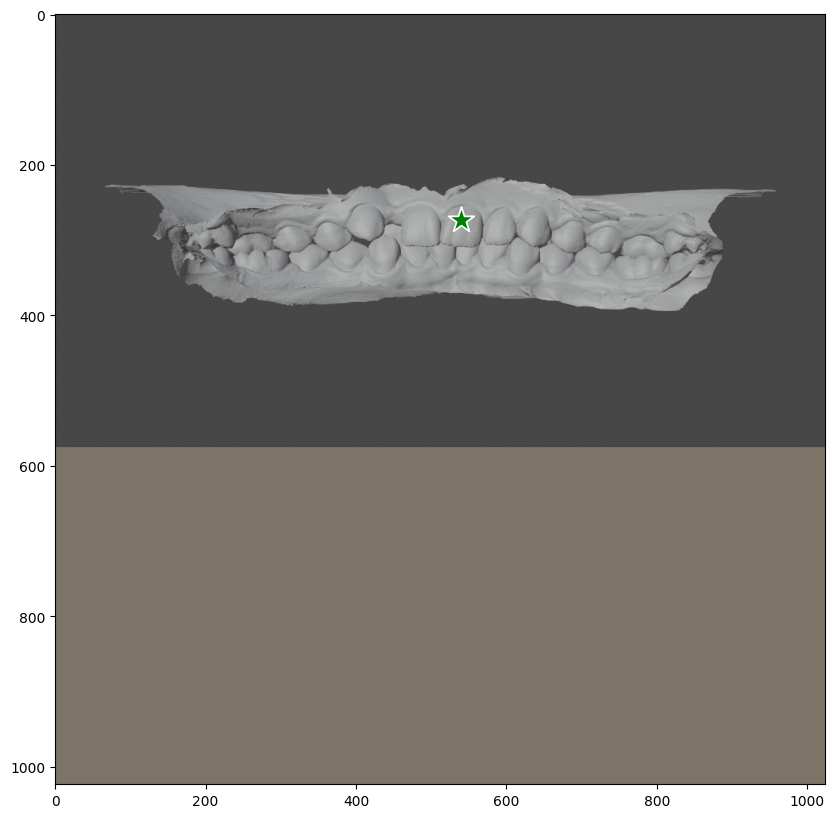

In [7]:
# Define the input point prompt
coords = np.array([
    [540, 272.5],
])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_points(coords, input_label, plt.gca())
plt.axis("on")
plt.show()

Now let's call the `predict` method of our model to get the segmentation masks.

**Note**: We don't call the model directly (`model(...)`) since placeholder prompts are
required to do so. Missing prompts are handled automatically by the predict method so we
call it instead. Also, when no box prompts are present, the points and labels need to be
padded with a zero point prompt and `-1` label prompt respectively. The cell below
demonstrates how this works.

In [8]:
print(type(image), image.shape, image.dtype)
print(type(coords), coords.shape, coords.dtype)
print(type(input_label), input_label.shape, input_label.dtype)


<class 'jaxlib.xla_extension.ArrayImpl'> (1024, 1024, 3) float32
<class 'numpy.ndarray'> (1, 2) float64
<class 'numpy.ndarray'> (1,) int64


In [9]:
import numpy as np
import tensorflow as tf

# Convert JAX array to NumPy array
image_np = np.array(image, dtype="float32")

# Ensure coords and labels are also NumPy arrays
coords = np.asarray(coords, dtype="float32")
input_label = np.asarray(input_label, dtype="int32")

# Optional: pad if your model expects a fixed number of points (e.g., 3 or 5)
max_points = 3
pad_points = max_points - len(coords)
if pad_points > 0:
    coords = np.concatenate([coords, np.zeros((pad_points, 2), dtype="float32")], axis=0)
    input_label = np.concatenate([input_label, np.full((pad_points,), -1, dtype="int32")], axis=0)

# Convert to TensorFlow tensors for predict()
outputs = model.predict({
    "images": tf.convert_to_tensor(image_np[np.newaxis, ...], dtype=tf.float32),
    "points": tf.convert_to_tensor(coords[np.newaxis, ...], dtype=tf.float32),
    "labels": tf.convert_to_tensor(input_label[np.newaxis, ...], dtype=tf.int32),
})


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


`SegmentAnythingModel.predict` returns two outputs. First are logits (segmentation masks)
of shape `(1, 4, 256, 256)` and the other are the IoU confidence scores (of shape `(1,
4)`) for each mask predicted. The pretrained SAM model predicts four masks: the first is
the best mask the model could come up with for the given prompts, and the other 3 are the
alternative masks which can be used in case the best prediction doesn't contain the
desired object. The user can choose whichever mask they prefer.

Let's visualize the masks returned by the model!

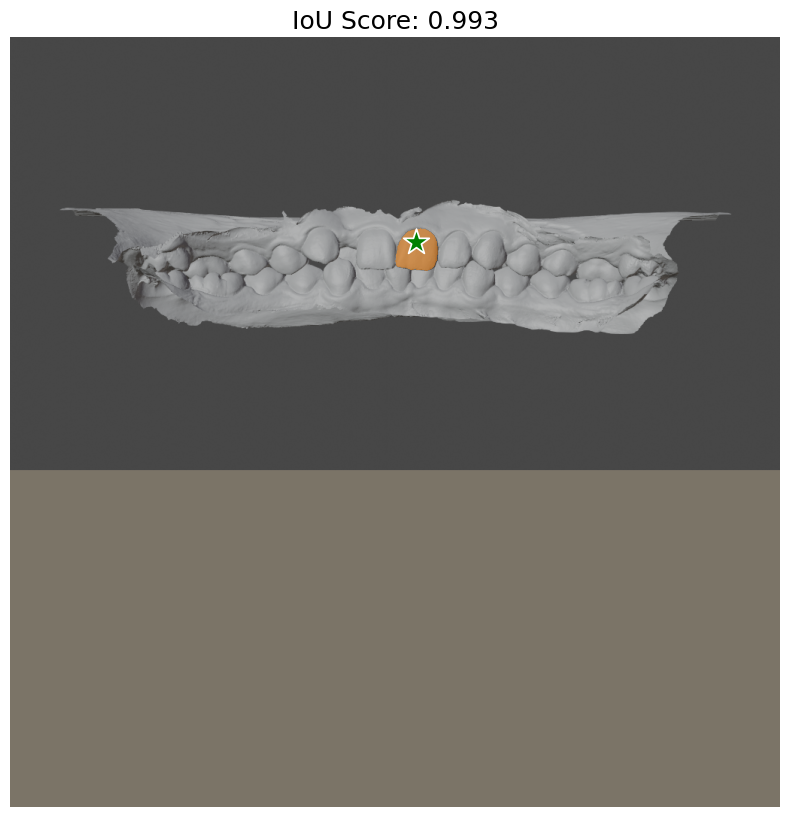

In [10]:
# Resize the mask to our image shape i.e. (1024, 1024)
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
# Convert the logits to a numpy array
# and convert the logits to a boolean mask
mask = ops.convert_to_numpy(mask) > 0.0
iou_score = ops.convert_to_numpy(outputs["iou_pred"][0][1])

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca(), random_color=True)
show_points(coords, input_label, plt.gca())
plt.title(f"IoU Score: {iou_score:.3f}", fontsize=18)
plt.axis("off")
plt.show()

As expected, the model returns a segmentation mask for the truck's window pane. But, our
point prompt can also mean a range of other things. For example, another possible mask
that contains our point is just the right side of the window pane or the whole truck.

Let's also visualize the other masks the model has predicted.

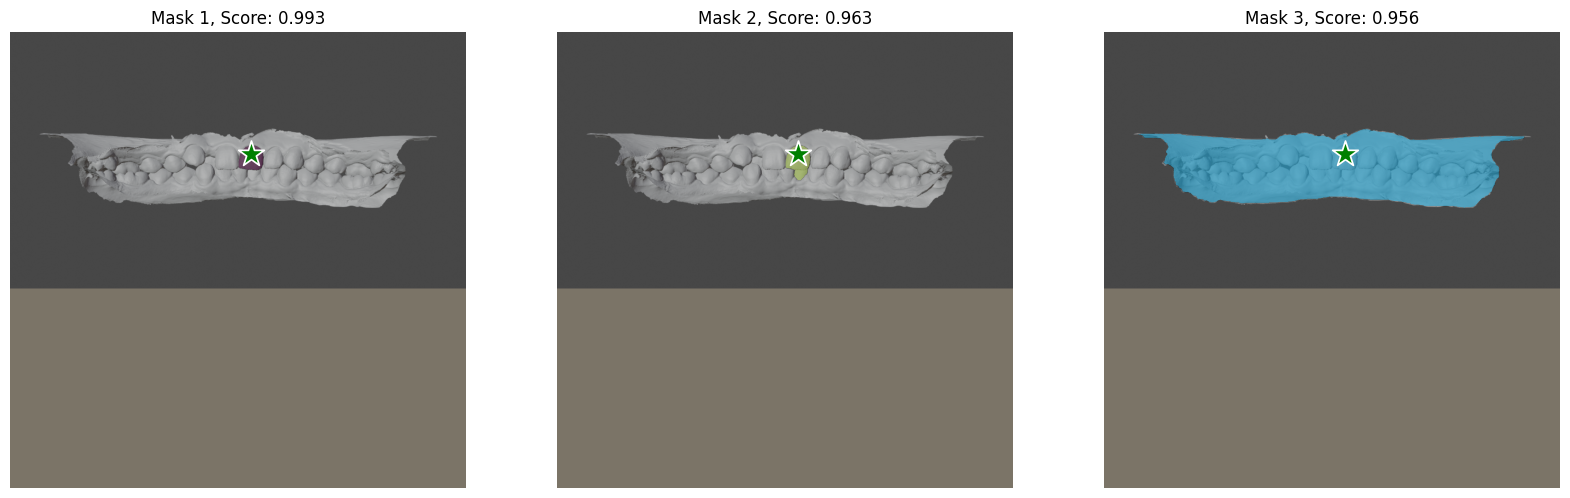

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 60))
masks, scores = outputs["masks"][0][1:], outputs["iou_pred"][0][1:]
for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = inference_resizing(mask[..., None], pad=False)[..., 0]
    mask, score = map(ops.convert_to_numpy, (mask, score))
    mask = 1 * (mask > 0.0)
    ax[i].imshow(ops.convert_to_numpy(image) / 255.0)
    show_mask(mask, ax[i], random_color=True)
    show_points(coords, input_label, ax[i])
    ax[i].set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=12)
    ax[i].axis("off")
plt.show()

Nice! SAM was able to capture the ambiguity of our point prompt and also returned other
possible segmentation masks.

## Box Prompts

Now, let's see how we can prompt the model using boxes. The box is specified using two
points, the top-left corner and the bottom-right corner of the bounding box in xyxy
format. Let's prompt the model using a bounding box around the left front tyre of the
truck.

In [23]:
def predict_box(input_box):
  outputs = model.predict(
    {"images": image[np.newaxis, ...], "boxes": input_box[np.newaxis, np.newaxis, ...]}
  )
  mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
  mask = ops.convert_to_numpy(mask) > 0.0
  show_mask(mask, plt.gca(), random_color=True)
  return mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


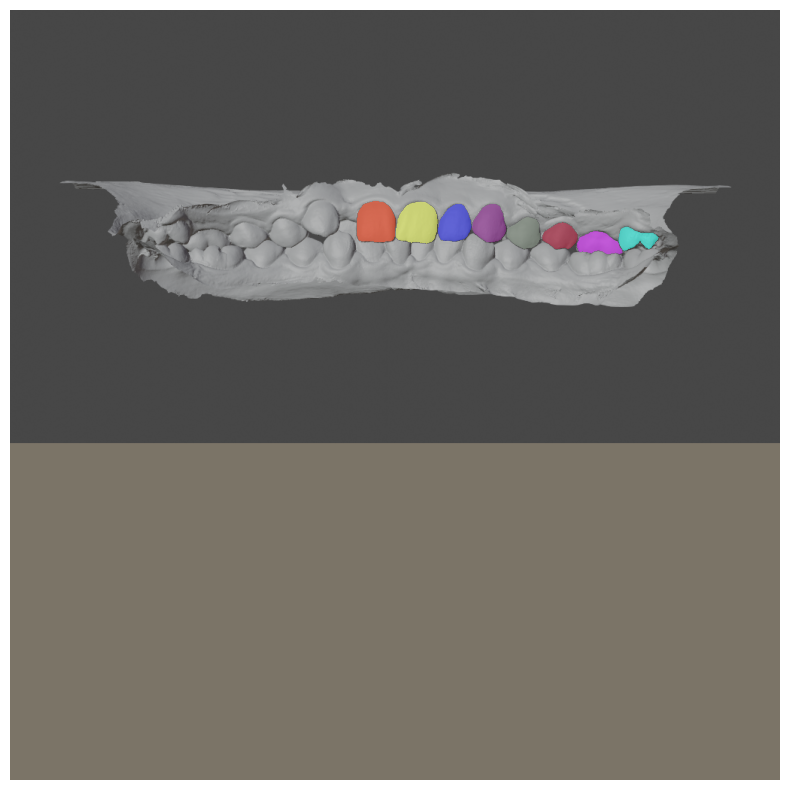

In [52]:
plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)

input_box = np.array([[455, 242.5], [510, 312.5]])
mask = predict_box(input_box)

input_box_2 = np.array([[510, 242.5], [570, 312.5]])
mask_2 = predict_box(input_box_2)

input_box_3 = np.array([[570, 242.5], [615, 312.5]])
mask_3 = predict_box(input_box_3)

input_box_4 = np.array([[615, 242.5], [660, 312.5]])
mask_4 = predict_box(input_box_4)

input_box_5 = np.array([[660, 262.5], [710, 312.5]])
mask_5 = predict_box(input_box_5)

input_box_6 = np.array([[710, 282.5], [760, 322.5]])
mask_6 = predict_box(input_box_6)

input_box_7 = np.array([[760, 282.5], [810, 322.5]])
mask_7 = predict_box(input_box_7)

input_box_8 = np.array([[810, 282.5], [870, 322.5]])
mask_8 = predict_box(input_box_8)

#show_box(input_box_8, plt.gca())
plt.axis("off")
plt.show()

Boom! The model perfectly segments out the left front tyre in our bounding box.

## Combining prompts

To get the true potential of the model out, let's combine box and point prompts and see
what the model does.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


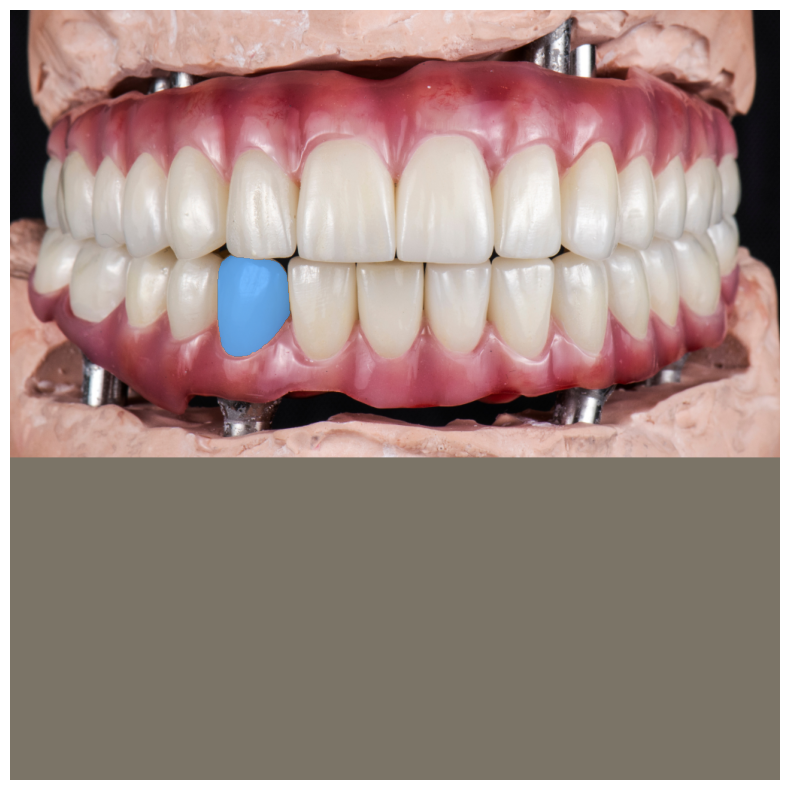

In [ ]:
# Let's specify the box
input_box = np.array([[240, 340], [400, 500]])
# Let's specify the point and mark it background
input_point = np.array([[325, 325]])
input_label = np.array([0])

outputs = model.predict(
    {
        "images": image[np.newaxis, ...],
        "points": input_point[np.newaxis, ...],
        "labels": input_label[np.newaxis, ...],
        "boxes": input_box[np.newaxis, np.newaxis, ...],
    }
)
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
# show_box(input_box, plt.gca())
# show_points(input_point, input_label, plt.gca())
plt.axis("off")
plt.show()

Voila! The model understood that the object we wanted to exclude from our mask was the
rim of the tyre.

## Text prompts

Finally, let's see how text prompts can be used along with KerasHub's
`SegmentAnythingModel`.

For this demo, we will use the
[offical Grounding DINO model](https://github.com/IDEA-Research/GroundingDINO).
Grounding DINO is a model that
takes as input a `(image, text)` pair and generates a bounding box around the object in
the `image` described by the `text`. You can refer to the
[paper](https://arxiv.org/abs/2303.05499) for more details on the implementation of the
model.

For this part of the demo, we will need to install the `groundingdino` package from
source:

```
pip install -U git+https://github.com/IDEA-Research/GroundingDINO.git
```

Then, we can install the pretrained model's weights and config:

In [ ]:
!!pip install -U git+https://github.com/IDEA-Research/GroundingDINO.git

['Collecting git+https://github.com/IDEA-Research/GroundingDINO.git',
 '  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-s3whk2yj',
 '  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-build-s3whk2yj',
 '  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 856dde20aee659246248e20734ef9ba5214f5e44',
 '  Preparing metadata (setup.py) ... \x1b[?25l\x1b[?25hdone',
 'Requirement already satisfied: torch in /usr/local/lib/python3.12/dist-packages (from groundingdino==0.1.0) (2.8.0+cu126)',
 'Requirement already satisfied: torchvision in /usr/local/lib/python3.12/dist-packages (from groundingdino==0.1.0) (0.23.0+cu126)',
 'Requirement already satisfied: transformers in /usr/local/lib/python3.12/dist-packages (from groundingdino==0.1.0) (4.57.0)',
 'Collecting addict (from groundingdino==0.1.0)',
 '  Downloading addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)',
 'Collecting 

In [ ]:
!!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py

[]

In [ ]:
!pip install matplotlib-venn

In [ ]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [ ]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.5_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.8 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=0967140abc9bd78c6a450cb342a04110e5ebd864a9dfb8a5295a2d0dd490f06b
  Stored in directory: /root/.cache/pip/wheels/29/20/ab/f101da7b245b996aa097685ef742243725ea6150f5b3b6d9ed
Successfully built libarchive


In [ ]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 91.1 MB/s eta 0:00:00


In [ ]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [ ]:
!pip install git+https://github.com/IDEA-Research/GroundingDINO.git


  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-cq1xoyen
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-build-cq1xoyen
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 856dde20aee659246248e20734ef9ba5214f5e44
  Preparing metadata (setup.py) ... done
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached yapf-0.43.0-py3-none-any.whl.metadata (46 kB)
  Using cached supervision-0.26.1-py3-none-any.whl.metadata (13 kB)
Using cached supervision-0.26.1-py3-none-any.whl (207 kB)
Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
Using cached yapf-0.43.0-py3-none-any.whl (256 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel fo

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install opencv-python pycocotools tqdm supervision
!pip install groundingdino-py

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached supervision-0.26.1-py3-none-any.whl.metadata (13 kB)
Using cached supervision-0.26.1-py3-none-any.whl (207 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached yapf-0.43.0-py3-none-any.whl.metadata (46 kB)
Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
Using cached yapf-0.43.0-py3-none-any.whl (256 kB)
  Created wheel for groundingdino-py: filename=groundingdino_py-0.4.0-py2.py3-none-any.whl size=88737 sha256=ff1b529df2661cb6d7960a7b330945f3f540a2241bceeee9b2cdb49018f2aa4f
  Stored in directory: /root/.cache/pip/wheels/74/c4/d6/2c6ded61819d391715b4f1ae483f2cfdc8f2eeb6bbb63e748b
Successfully built groundingdino-py
  Attempting uninstall: supervision
    Found existing installation: supervision 0.26.1
    Uninstalling supervision-0.26.1:
      Successfully uninst

In [ ]:
from groundingdino.util.inference import Model as GroundingDINO

CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

grounding_dino = GroundingDINO(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Let's load an image of a dog for this part!

1236492/1236492 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


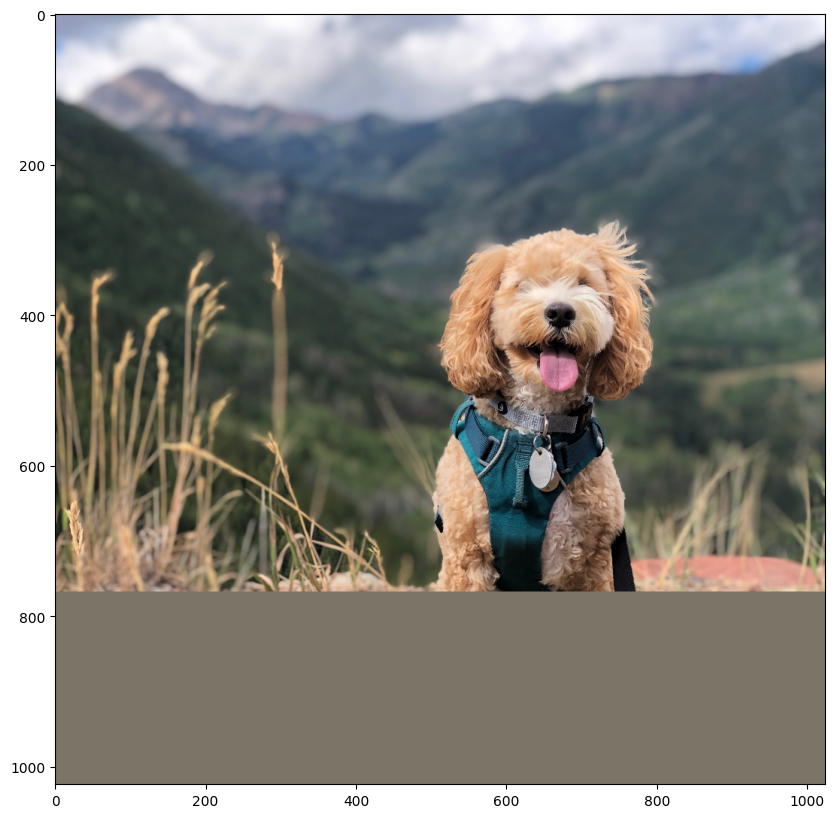

In [ ]:
filepath = keras.utils.get_file(
    origin="https://storage.googleapis.com/keras-cv/test-images/mountain-dog.jpeg"
)
image = np.array(keras.utils.load_img(filepath))
image = ops.convert_to_numpy(inference_resizing(image))

plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)
plt.axis("on")
plt.show()

We first predict the bounding box of the object we want to segment using the Grounding
DINO model. Then, we prompt the SAM model using the bounding box to get the segmentation
mask.

Let's try to segment out the harness of the dog. Change the image and text below to
segment whatever you want using text from your image!

In [ ]:
# Let's predict the bounding box for the harness of the dog
boxes = grounding_dino.predict_with_caption(image.astype(np.uint8), "harness")
boxes = np.array(boxes[0].xyxy)

outputs = model.predict(
    {
        "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
        "boxes": boxes.reshape(-1, 1, 2, 2),
    },
    batch_size=1,
)

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1625: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


And that's it! We got a segmentation mask for our text prompt using the combination of
Gounding DINO + SAM! This is a very powerful technique to combine different models to
expand the applications!

Let's visualize the results.

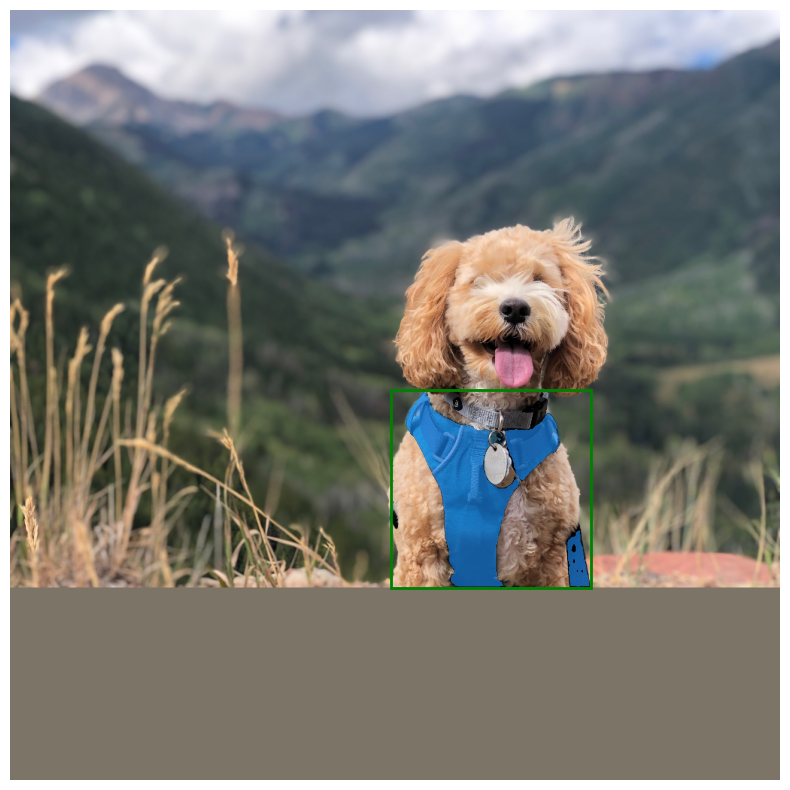

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)

for mask in outputs["masks"]:
    mask = inference_resizing(mask[0][..., None], pad=False)[..., 0]
    mask = ops.convert_to_numpy(mask) > 0.0
    show_mask(mask, plt.gca())
    show_box(boxes, plt.gca())

plt.axis("off")
plt.show()

## Optimizing SAM

You can use `mixed_float16` or `bfloat16` dtype policies to gain huge speedups and memory
optimizations at releatively low precision loss.

In [27]:
# Load our image
image = np.array(keras.utils.load_img("truck.jpg"))
image = inference_resizing(image)

# Specify the prompt
input_box = np.array([[240, 340], [400, 500]])

# Let's first see how fast the model is with float32 dtype
time_taken = timeit.repeat(
    'model.predict({"images": image[np.newaxis, ...], "boxes": input_box[np.newaxis, np.newaxis, ...]}, verbose=False)',
    repeat=3,
    number=3,
    globals=globals(),
)
print(f"Time taken with float32 dtype: {min(time_taken) / 3:.10f}s")

# Set the dtype policy in Keras
keras.mixed_precision.set_global_policy("mixed_float16")

model = keras_hub.models.SAMImageSegmenter.from_preset("sam_huge_sa1b")

time_taken = timeit.repeat(
    'model.predict({"images": image[np.newaxis, ...], "boxes": input_box[np.newaxis,np.newaxis, ...]}, verbose=False)',
    repeat=3,
    number=3,
    globals=globals(),
)
print(f"Time taken with float16 dtype: {min(time_taken) / 3:.10f}s")

Time taken with float32 dtype: 2.1948750647s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Time taken with float16 dtype: 0.6345404577s


Here's a comparison of KerasHub's implementation with the original PyTorch
implementation!

![benchmark](https://github.com/tirthasheshpatel/segment_anything_keras/blob/main/benchmark.png?raw=true)

The script used to generate the benchmarks is present
[here](https://github.com/tirthasheshpatel/segment_anything_keras/blob/main/Segment_Anything_Benchmarks.ipynb).

## Conclusion

KerasHub's `SegmentAnythingModel` supports a variety of applications and, with the help of
Keras 3, enables running the model on TensorFlow, JAX, and PyTorch! With the help of XLA
in JAX and TensorFlow, the model runs several times faster than the original
implementation. Moreover, using Keras's mixed precision support helps optimize memory use
and computation time with just one line of code!

For more advanced uses, check out the
[Automatic Mask Generator demo](https://github.com/tirthasheshpatel/segment_anything_keras/blob/main/Segment_Anything_Automatic_Mask_Generator_Demo.ipynb).